In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from gensim.models import Phrases
from gensim.corpora import Dictionary
from stop_words import get_stop_words
from nltk.tokenize import sent_tokenize
from keras import backend as K
from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, Input, concatenate, Reshape, merge, dot
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams, make_sampling_table
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
from random import shuffle
import time
import pylab as pl
from ipywidgets import FloatProgress
from IPython import display
import matplotlib.pyplot as plt
from kerastoolbox.visu import plot_weights
from scipy import spatial
%matplotlib notebook

Using TensorFlow backend.


In [2]:
# set backends of keras
sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=8))
K.set_session(sess)

In [3]:
# load dictionary from disk
dictionary = Dictionary.load("dictionary_least_dfs_8_vocab_13152.pkl")
n_vocab = len(dictionary)

In [38]:
# create embedding model
vec_dim = 256
embedding_layer = Embedding(input_dim=n_vocab, output_dim=vec_dim, input_length=1, name='embedding')
input_target = Input((1,))
input_context = Input((1,))
target = embedding_layer(input_target)
context = embedding_layer(input_context)
# generate similarity model output
similarity = dot([target, context], normalize=True, axes=2)
similarity = Reshape((1,))(similarity)
# generate pure vector model output
vector = Reshape((vec_dim,))(target)
# generate training model output
target = GaussianNoise(0.15)(target)
context = GaussianNoise(0.15)(context)
dot_product = dot([target, context], normalize=True, axes=2)
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
# output = Activation("sigmoid")(dot_product)
output = dot_product

# generate training and checking models
training_model = Model(inputs=[input_target, input_context], output=output)
similarity_model = Model(inputs=[input_target, input_context], output=similarity)
vector_model = Model(inputs=[input_target], output=vector)

# compile for training
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print model summary
print("summary for training_model:", training_model.summary())
print("summary for similarity_model:", similarity_model.summary())
print("summary for vector_model:", vector_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 256)       3366912     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_3 (GaussianNoise (None, 1, 256)       0           embedding[0][0]                  
__________

/Users/andywu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("re...)`
/Users/andywu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("re...)`
/Users/andywu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("re...)`


In [58]:
# train embedding
# load train data from file
training_pairs_labels = np.load("training pairs and labels.npz")
training_pairs = [training_pairs_labels['target'], training_pairs_labels['context']]
training_labels = training_pairs_labels['labels']
print(training_pairs[0].shape)
print(training_labels.shape)
# train the model
training_model.fit(training_pairs, training_labels, epochs=10, batch_size=1024, shuffle=True, 
                  verbose=1, validation_split=0.1, callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=4)])

# evaluating the model
score = training_model.evaluate([training_pairs[0][-10000:], training_pairs[1][-10000:]],
                                    training_labels[-10000:], verbose=1)
print("evaluation result is: ", score)
# save to file
filepath = "embedding_layer_acc{}.h5".format(score[1])
training_model.save_weights(filepath)

(3588714,)
(3588714,)
Train on 3229842 samples, validate on 358872 samples
Epoch 1/10
3229842/3229842 [==============================] - 201s 62us/step - loss: 0.4587 - acc: 0.7823 - val_loss: 0.5189 - val_acc: 0.7529
Epoch 2/10
3229842/3229842 [==============================] - 200s 62us/step - loss: 0.4583 - acc: 0.7826 - val_loss: 0.5195 - val_acc: 0.7529
Epoch 3/10
3229842/3229842 [==============================] - 200s 62us/step - loss: 0.4572 - acc: 0.7835 - val_loss: 0.5198 - val_acc: 0.7528
Epoch 4/10
3229842/3229842 [==============================] - 195s 60us/step - loss: 0.4562 - acc: 0.7841 - val_loss: 0.5193 - val_acc: 0.7527
Epoch 5/10
10000/10000 [==============================] - 0s 21us/step
evaluation result is:  [0.52187004241943358, 0.75119999999999998]


In [41]:
score = training_model.evaluate([training_pairs[0][-10000:], training_pairs[1][-10000:]],
                                    training_labels[-10000:], verbose=1)
print("evaluation result is: ", score)
# save to file
filepath = "embedding_layer_acc{}.h5".format(score[1])
training_model.save_weights(filepath)

10000/10000 [==============================] - 0s 23us/step
evaluation result is:  [0.52591802802085874, 0.74960000000000004]


In [ ]:
# output similar words for a random word
index_target = input("target word: ")
index_target = dictionary.token2id[index_target]
if index_target == dictionary.token2id['hi']:
    index_target = np.random.randint(n_vocab)
    dictionary.get(index_target)
target = np.array([index_target]*(n_vocab))
match = np.array(range(n_vocab))
result = similarity_model.predict_on_batch([target, match])
result = sorted(enumerate([item for item_0 in result for item in item_0]), key=lambda x: -x[1])
print("for word: {}, the best similarities are: ".format(dictionary.get(index_target)))
for i in range(10):
    print(dictionary.get(result[i][0]), result[i][1])

In [85]:
# output analogical words for a random word
index_target = input("target word ")
index_target = dictionary.token2id[index_target]
index_comp = input("comp word ")
index_comp = dictionary.token2id[index_comp]
index_target2 = input("new target word ")
index_target2 = dictionary.token2id[index_target2]

target_word = dictionary.get(index_target)
comp_word = dictionary.get(index_comp)
target_word2 = dictionary.get(index_target2)
target_vec = vector_model.predict(np.array([index_target]))
comp_vec = vector_model.predict(np.array([index_comp]))
target2_vec = vector_model.predict(np.array([index_target2]))
dis_vec = comp_vec - target_vec

match = np.array(range(n_vocab))
result = np.array(vector_model.predict_on_batch(match))
result -= target2_vec

cos_dis = []
for i in result:
    cos_dis.append(1 - spatial.distance.cosine(i, dis_vec))
cos_dis = sorted(enumerate([item for item in cos_dis]), key=lambda x: -x[1])

print(target_word, " to ", comp_word, " is ", target_word2, " to ")

for i in range(10):
    print(dictionary.get(cos_dis[i][0]), cos_dis[i][1])

target word money
comp word happy
new target word you


/Users/andywu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


money  to  happy  is  you  to 
happy 0.685017049313
funny 0.658618569374
often 0.654485225677
yet 0.651092410088
strange 0.630208313465
sad 0.62533813715
twist 0.624440550804
profound 0.623382747173
twists 0.621499657631
situations 0.619661688805


<IPython.core.display.Javascript object>


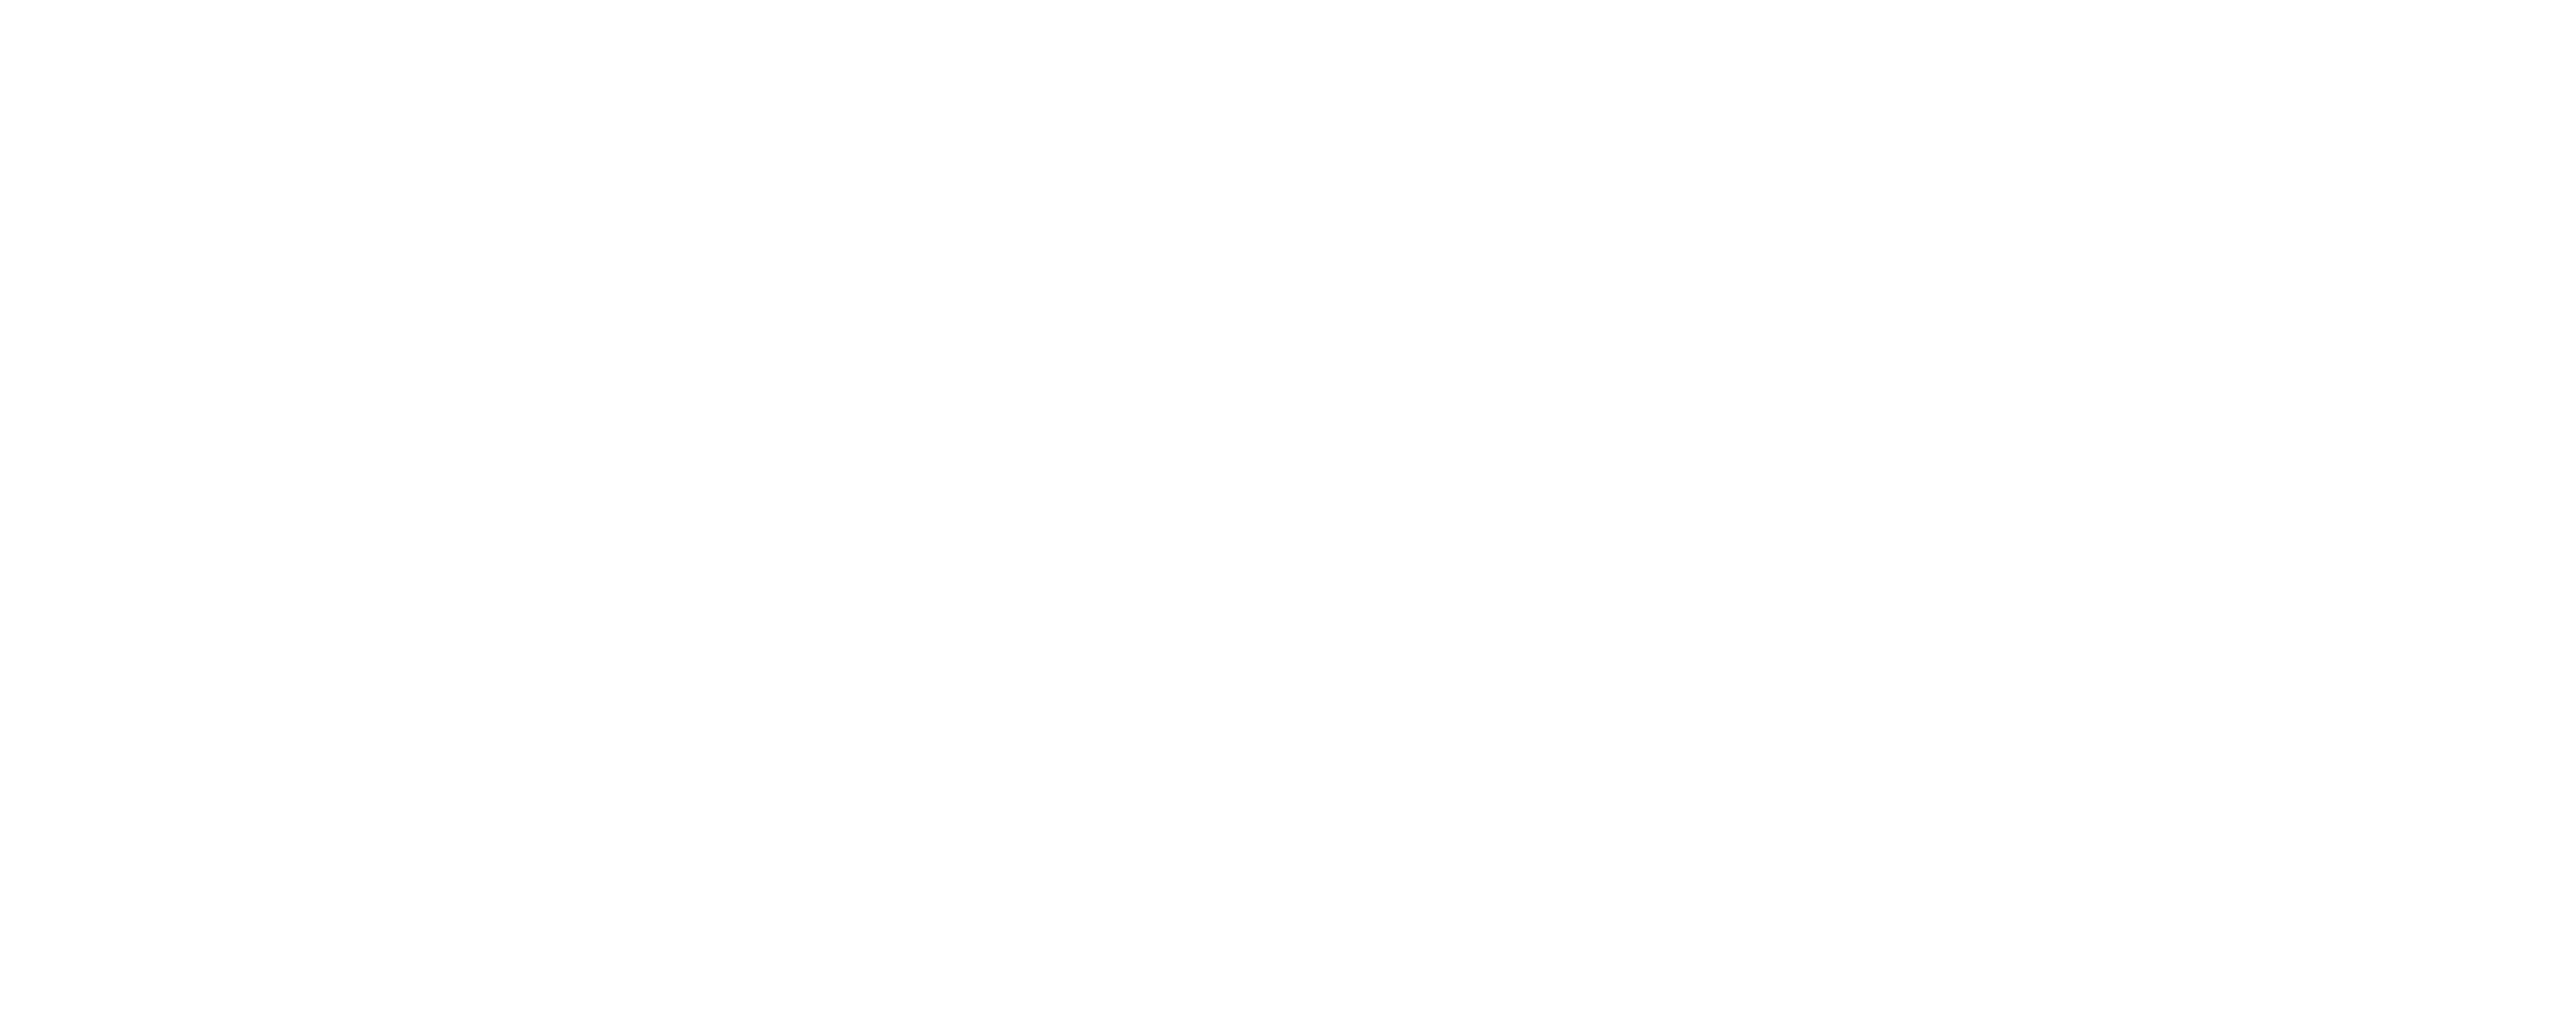

NameError: name 'train_texts' is not defined

In [58]:
# valuable example of training on batches manully
# train embedding and plot loss realtime
# turn on interactive plotting
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
fig.set_size_inches(20, 8)
# start epochs of training
for iteration in range(5):
    i = 0
    x = []
    y1 = []
    y2 = []
    shuffle(train_texts)
    batch_size = [128, 256, 256, 512, 1024]
    for text in train_texts:
        i += 1
        # concantenate all the pairs of input every 256 and feed to the train_on_batch to boost training efficiency
        if i % batch_size[iteration] == 0: 
            for j in range(20):
                loss = training_model.train_on_batch(training_pairs, training_labels)
                # plot the result dynamically
                if len(x) > 10:
                    x.pop(0)
                    y1.pop(0)
                    y2.pop(0)
                x.append(i)
                y1.append(loss[0])
                y2.append(loss[1])
                ax1.plot(x, y1, '-r')
                ax2.plot(x, y2, '-b')
                fig.canvas.draw()
                time.sleep(0.05)
                print(loss)
            training_pairs = []
            labels = []
        else: 
            pairs, labels = skipgrams(sequence=text, vocabulary_size=n_vocab, negative_samples=3.)
            pairs = [np.array(x) for x in zip(*pairs)]
            labels = np.array(labels)
            if len(training_pairs) == 0:
                training_pairs = pairs
                training_labels = labels
            else:
                training_pairs = [np.append(training_pairs[0], pairs[0]), np.append(training_pairs[1], pairs[1])]
                training_labels = np.append(training_labels, labels)
    print("{} epoch finished".format(i))
    # save check point
    filepath = "embedding_layer_acc:{}.h5".format(loss[1])
    training_model.save_weights(filepath)